In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

In [2]:
(train_X, train_Y), (test_X, test_Y) = load_data()
train_X = np.float32(train_X) / 255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
#Generator and Discriminator
class Generator(nn.Module):

  def __init__(self, input_dim=100, hidden_dim=1200, output_dim=28*28, context_dim=10):
      super(Generator, self).__init__()

      self.hidden1_z = nn.Sequential(
          nn.Linear(input_dim, 200),
          nn.Dropout(p=0.5),
          nn.ReLU()
      )

      self.hidden1_context = nn.Sequential(
          nn.Linear(context_dim, 1000),
          nn.Dropout(p=0.5),
          nn.ReLU()
      )

      self.hidden2 = nn.Sequential(
          nn.Linear(1200, 1200),
          nn.Dropout(p=0.5),
          nn.ReLU()
      )

      self.output = nn.Sequential(
          nn.Linear(1200, output_dim),
          nn.Sigmoid()
      )


  def forward(self, z, context):
    h1 = torch.cat((self.hidden1_z(z), self.hidden1_context(context)), dim=1)
    h2 = self.hidden2(h1)
    return self.output(h2)

class Discriminator(nn.Module):

  def __init__(self, input_dim=28*28, hidden_dim=240, output_dim=1, context_dim=10):
      super(Discriminator, self).__init__()

      self.hidden1_x = nn.Sequential(
          nn.Linear(input_dim, 240),
          nn.Dropout(p=0.5),
          nn.LeakyReLU()
      )

      self.hidden1_context = nn.Sequential(
          nn.Linear(context_dim, 50),
          nn.Dropout(p=0.5),
          nn.LeakyReLU()
      )

      self.hidden2 = nn.Sequential(
          nn.Linear(290, 240),
          nn.Dropout(p=0.5),
          nn.LeakyReLU()
      )

      self.output = nn.Sequential(
          nn.Linear(240, output_dim),
          nn.Sigmoid()
      )


  def forward(self, x, context):
    h1 = torch.cat((self.hidden1_x(x), self.hidden1_context(context)), dim=1)
    h2 = self.hidden2(h1)
    return self.output(h2)


In [5]:
#Helpers

def sample_noise(batch_size, latent_size=100, device="cpu"):
  return torch.rand((batch_size, latent_size), device=device)


def sample_minibatch(batch_size, device="cpu"):
  indices = torch.randperm(train_X.shape[0])[:batch_size]
  return (torch.from_numpy(train_X[indices]).to(torch.float).reshape(batch_size, -1).to(device),
          nn.functional.one_hot(torch.from_numpy(train_Y[indices]).to(torch.long), num_classes=10).to(torch.float).to(device)
  )

In [6]:
#Training loop

def training_loop(generator, discriminator, generator_optimizer,
                  discriminator_optimizer,
                  schedulers,
                  nb_epochs,
                  k=1,
                  batch_size=100,
                  device='cpu'):
  training_loss = {"generator": [], "discriminator": []}

  for epoch in tqdm(range(nb_epochs)):

    #Train the discriminator
    for _ in range(k):
      #Sample minibatch of m noise samples
      z = sample_noise(batch_size, device=device)
      #Samle minibatch of m examples data
      x, y = sample_minibatch(batch_size, device=device)

      #Updating the discriminator
      f_loss = nn.BCELoss()(discriminator(generator(z, y), y).squeeze(-1), torch.zeros(batch_size, device=device))
      r_loss = nn.BCELoss()(discriminator(x, y).squeeze(-1), torch.ones(batch_size, device=device))

      loss = (f_loss + r_loss) / 2.0
      discriminator_optimizer.zero_grad()
      loss.backward()
      discriminator_optimizer.step()
      training_loss["discriminator"].append(loss.item())

    #Train the generator
    #Sample minibatch of m noise samples
    z = sample_noise(batch_size, device=device)
    #Update the generator
    loss = nn.BCELoss()(discriminator(generator(z, y), y).squeeze(-1), torch.ones(batch_size, device=device))

    generator_optimizer.zero_grad()
    loss.backward()
    generator_optimizer.step()
    training_loss["generator"].append(loss.item())

    for scheduler in schedulers:
      scheduler.step()


  return training_loss


In [8]:
device = 'cuda:0'
generator = Generator().to(device)
discriminator = Discriminator().to(device)
z = torch.randn((8, 100)).to(device)
context = torch.randn((8, 10)).to(device)
x = generator(z, context)

p = discriminator(x, context)
print(p)

tensor([[0.4876],
        [0.5125],
        [0.4584],
        [0.4958],
        [0.4844],
        [0.5349],
        [0.4875],
        [0.5533]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [9]:
#Putting everything together

generator_optimizer = torch.optim.SGD(generator.parameters(),
                                      lr=0.1,
                                      momentum=0.5,
                                      )

discriminator_optimizer = torch.optim.SGD(discriminator.parameters(),
                                      lr=0.1,
                                      momentum=0.5,
                                      )

schedulers = [
    torch.optim.lr_scheduler.ExponentialLR(generator_optimizer, 1/1.00004),
    torch.optim.lr_scheduler.ExponentialLR(discriminator_optimizer, 1/1.00004),
]

training_loop(generator, discriminator, generator_optimizer, discriminator_optimizer, schedulers, 287_828, k=1, batch_size=100, device=device);

100%|██████████| 287828/287828 [43:23<00:00, 110.56it/s]


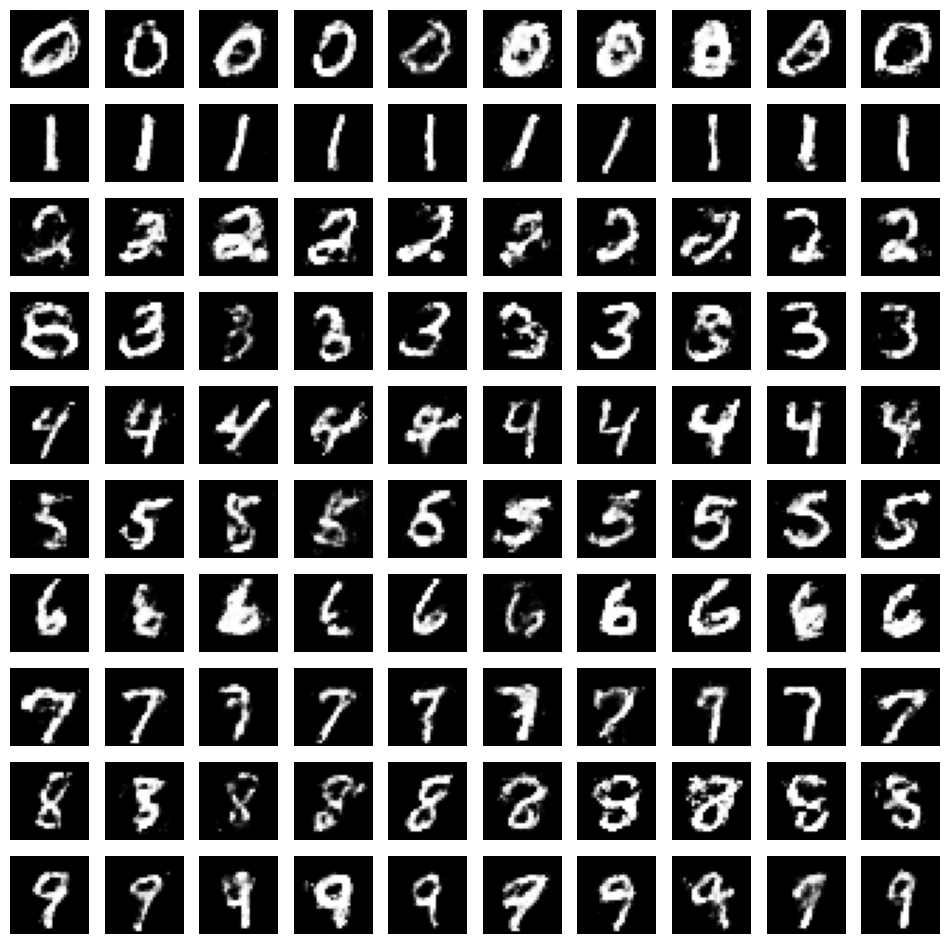

In [10]:
NB_IMAGES = 10
plt.figure(figsize=(12, 12))

for label in range(10):

  z = sample_noise(NB_IMAGES, device=device)
  context = nn.functional.one_hot(torch.ones(NB_IMAGES).long() * label, num_classes=10).float().to(device)
  x = generator(z, context).data.cpu().numpy()

  for i in range(NB_IMAGES):
    plt.subplot(10, 10, 10 * label  + 1 + i)
    plt.axis('off')
    plt.imshow(x[i].reshape(28, 28), cmap='gray')

plt.savefig('cgan_generated_samples.png')